In [30]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import os
import matplotlib.pyplot as plt
import tifffile
import numpy as np
from sklearn.model_selection import train_test_split

In [31]:
files = []
for i in range(20):
    files.append(os.getcwd() + '\\812_plate\\' + str(i) + '.tif' )

In [32]:
from cellpose.io import imread
from cellpose import core
from cellpose import models

model = models.Cellpose(model_type='nuclei')

use_GPU = core.use_gpu()
import time
imgs = [imread(f) for f in files]
nimg = len(imgs)
channels = [[0,0]]
start = time.time()
masks, flows, styles, diams = model.eval(imgs, diameter=None, channels=channels)

end = time.time()
print("Time consumed in working: ",end - start)

could not estimate diameter, does not work on non-2D images


Time consumed in working:  90.14224600791931


In [33]:
print(masks[0].shape)

(1080, 1080)


In [35]:
for i in range(len(masks)):
    tifffile.imsave(os.getcwd() + '\\812_plate_masks\\' + str(i) + '.tif', masks[i])

C:\Users\rz200\AppData\Local\Temp\ipykernel_14352\4117647828.py:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(os.getcwd() + '\\812_plate_masks\\' + str(i) + '.tif', masks[i])


In [36]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [37]:
def randomCrop(img, mask, width, height):
    assert img.shape[0] >= height
    assert img.shape[1] >= width
    assert img.shape[0] == mask.shape[0]
    assert img.shape[1] == mask.shape[1]
    x = random.randint(0, img.shape[1] - width)
    y = random.randint(0, img.shape[0] - height)
    img = img[y:y+height, x:x+width]
    mask = mask[y:y+height, x:x+width]
    return img, mask

In [38]:
def padding(array, xx, yy):
        h = array.shape[0]
        w = array.shape[1]
        a = (xx - h) // 2
        aa = xx - a - h
        b = (yy - w) // 2
        bb = yy - b - w
        return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [39]:
def get_data(img_path,mask_path,img_ids,upper_lim=0):
    full_original_imgs = []
    full_original_masks = []
    for i in img_ids:
        print(str(i) + '/' + str(len(img_ids)))
        file_path = img_path + '\\' + str(i) + '.tif'
        image = tifffile.imread(file_path)
        image = np.squeeze(image)
        full_original_imgs.append(image)

        file_path = mask_path + '\\' + str(i) + '.tif'
        mask = tifffile.imread(file_path)
        mask = np.squeeze(mask)
        full_original_masks.append(mask)

    initial_data = []
    for i in range(len(full_original_imgs)):
        print(str(i) + '/' + str(len(full_original_imgs)))
        img = full_original_imgs[i]
        images = [img[:, :, 0],img[:, :, 1],img[:, :, 2],img[:, :, 3]]   
        initial_data.append((full_original_masks[i],images))

    cropped_imgs = []
    cropped_masks = []
    
    j = 0
    for data in initial_data:
        print(str(j) + '/' + str(len(initial_data)))
        j += 1
        mask = data[0]
        images = data[1]
        for img in images:
            for i in range(500):
                crop_width = random.randint(5,250)
                crop_height = random.randint(5,250)
                crop_img, crop_mask = randomCrop(img, mask, crop_width, crop_height)
                
                #pad the images to (250,250)
                crop_img = padding(crop_img,250,250)
                crop_mask = padding(crop_mask,250,250)
                crop_mask = (crop_mask > 0) * 1

                #expand the dims
                crop_img = np.expand_dims(crop_img,-1)
                crop_mask = np.expand_dims(crop_mask,-1)

                #move the axis
                crop_img = np.moveaxis(crop_img, -1, 0)
                crop_mask = np.moveaxis(crop_mask,-1,0)

                #to torch
                crop_img = torch.from_numpy(crop_img.astype(np.float))
                crop_mask = torch.from_numpy(crop_mask.astype(np.float))

                cropped_imgs.append(crop_img)
                cropped_masks.append(crop_mask)

    if upper_lim != 0:
        return cropped_imgs[:upper_lim], cropped_masks[:upper_lim]

    return cropped_imgs, cropped_masks

unique vals: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178]
count non-zeros: 25314
count zeros: 1141086
percentage zeros: 97.82973251028807


unique vals: [0 1]
count non-zeros: 25314
count zeros: 1141086
percentage zeros: 97.82973251028807


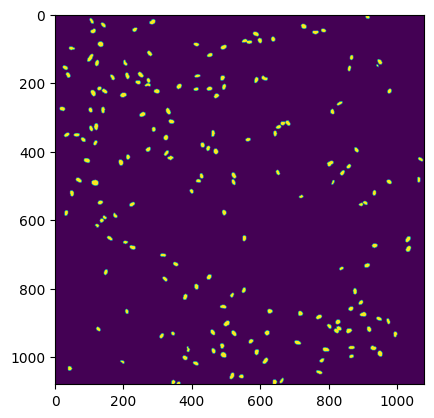

In [40]:
img_path = os.getcwd() + '\812_plate_masks'
file_path = img_path + '\\' + str(0) + '.tif'
image = tifffile.imread(file_path)
image = np.squeeze(image)

im_bin = (image > 0) *1

def count_0(image):
    unique = np.unique(image)
    non_zeros = np.count_nonzero(image)
    zeros = np.count_nonzero(image == 0)

    print('unique vals:',unique)
    print('count non-zeros:',non_zeros)
    print('count zeros:', zeros)
    print('percentage zeros:',str((zeros/(non_zeros+zeros))*100))

count_0(image)
print('\n')
count_0(im_bin)

plt.imshow(im_bin)

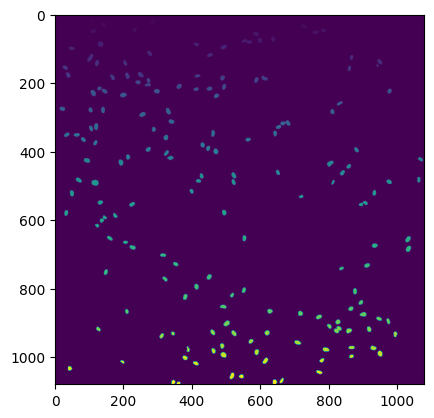

In [41]:
plt.imshow(image)

In [42]:
def get_train_test_data(img_path, mask_path, img_ids, test_size=0.3, upper_lim=0):
    img_data, mask_data = get_data(img_path, mask_path, img_ids, upper_lim)
    X_train, X_test, y_train, y_test = train_test_split(img_data, mask_data, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test

In [43]:
img_path = os.getcwd() + '\812_plate'
mask_path = os.getcwd() + '\812_plate_masks'
img_ids = [1,2,3,4,5,6]
img_data, mask_data = get_data(img_path, mask_path, img_ids, 10000)

print('Num imgs:',len(img_data))
print('Num masks:',len(mask_data))

1/6
2/6
3/6
4/6
5/6
6/6
0/6
1/6
2/6
3/6
4/6
5/6
0/6


C:\Users\rz200\AppData\Local\Temp\ipykernel_14352\2074010971.py:52: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  crop_img = torch.from_numpy(crop_img.astype(np.float))
C:\Users\rz200\AppData\Local\Temp\ipykernel_14352\2074010971.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  crop_mask = torch.from_numpy(crop_mask.astype(np.float))


1/6
2/6
3/6
4/6
5/6
Num imgs: 10000
Num masks: 10000


In [44]:
X_train, X_test, y_train, y_test = get_train_test_data(img_path, mask_path, img_ids, upper_lim=10000)

1/6
2/6
3/6
4/6
5/6
6/6
0/6
1/6
2/6
3/6
4/6
5/6
0/6


C:\Users\rz200\AppData\Local\Temp\ipykernel_14352\2074010971.py:52: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  crop_img = torch.from_numpy(crop_img.astype(np.float))
C:\Users\rz200\AppData\Local\Temp\ipykernel_14352\2074010971.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  crop_mask = torch.from_numpy(crop_mask.astype(np.float))


1/6
2/6
3/6
4/6
5/6


In [45]:
print(np.unique(y_train[0]))

[0. 1.]


In [46]:
print(type(X_train[0]))

<class 'torch.Tensor'>


In [47]:
plt.imshow(np.moveaxis(X_train[0], -1, 0))

TypeError: transpose() received an invalid combination of arguments - got (list), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


In [48]:
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))


6700 6700
3300 3300


In [49]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage, Resize, ToTensor

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

#transforms = transforms.Compose([transforms.CenterCrop((250,250))])

trainDS = []
for i in range(len(X_train)):
	trainDS.append((X_train[i],y_train[i]))
	#trainDS.append((transforms(X_train[i]),transforms(y_train[i])))

testDS = []
for i in range(len(X_test)):
    testDS.append((X_test[i],y_test[i]))

print(len(trainDS),len(testDS))

trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=5, pin_memory=PIN_MEMORY,
	num_workers=2)

testLoader = DataLoader(testDS, shuffle=True,
	batch_size=5, pin_memory=PIN_MEMORY,
	num_workers=2)



6700 3300


In [50]:
os.cpu_count()

24

In [51]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import ReLU

class Block(Module):
	
	def __init__(self, inChannels, outChannels):
		super().__init__()
		self.conv1 = Conv2d(inChannels, outChannels, 4)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 4)

	def forward(self, x):
		return self.conv2(self.relu(self.conv1(x))) #CONV->RELU->CONV

In [52]:
from torch.nn import ModuleList
from torch.nn import MaxPool2d

class Encoder(Module):

	def __init__(self, channels=(1, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList([Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)

	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

In [53]:
from torch.nn import ConvTranspose2d
from torchvision.transforms import CenterCrop

class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList([ConvTranspose2d(channels[i], channels[i + 1], 2, 2)for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList([Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])

	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
		
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

In [54]:
class UNet(Module):
	def __init__(self, encChannels=(1, 16, 32, 64), decChannels=(64, 32, 16), nbClasses=1, retainDim=True, outSize=(250,  250)):
		super().__init__()
		# initialize the encoder and decoder
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)
		# initialize the regression head and store the class variables
		self.head = Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize

	def forward(self, x):
		# grab the features from the encoder
		encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		decFeatures = self.decoder(encFeatures[::-1][0],
			encFeatures[::-1][1:])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(decFeatures)
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retainDim:
			map = F.interpolate(map, self.outSize)
		# return the segmentation map
		map = torch.sigmoid(map)
		return map

In [55]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [56]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [57]:
class WeightedFocalLoss(nn.Module):
    "Non weighted version of Focal Loss"
    def __init__(self, alpha=.25, gamma=2):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor([alpha, 1-alpha]).cuda()
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        targets = targets.type(torch.long)
        at = self.alpha.gather(0, targets.data.view(-1))
        print('at shape:',at.shape)
        pt = torch.exp(-BCE_loss)
        pt = pt.data.view(-1)
        print('pt shape:',pt.shape)

        BCE_loss = BCE_loss.data.view(-1)
        print('BCE_loss shape:',BCE_loss.shape)
        F_loss = at*(1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

In [58]:
class FocalLoss(nn.CrossEntropyLoss):
    ''' Focal loss for classification tasks on imbalanced datasets '''

    def __init__(self, gamma, alpha=None, ignore_index=-100, reduction='none'):
        super().__init__(weight=alpha, ignore_index=ignore_index, reduction='none')
        self.reduction = reduction
        self.gamma = gamma

    def forward(self, input_, target):
        cross_entropy = super().forward(input_, target)
        # Temporarily mask out ignore index to '0' for valid gather-indices input.
        # This won't contribute final loss as the cross_entropy contribution
        # for these would be zero.
        target = target * (target != self.ignore_index).long()
        input_prob = torch.gather(F.softmax(input_, 1), 1, target.unsqueeze(1))
        loss = torch.pow(1 - input_prob, self.gamma) * cross_entropy
        return torch.mean(loss) if self.reduction == 'mean' else torch.sum(loss) if self.reduction == 'sum' else loss

In [59]:
ALPHA = 0.8
GAMMA = 2

class FocalLoss_X(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss_X, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        
        BCE = F.binary_cross_entropy(inputs.float(), targets.float(), reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

In [60]:
class WeightedBCE(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(WeightedBCE, self).__init__()

    def forward(self,inputs,targets):
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #get weights of pos and neg
        w_pos = torch.count_nonzero(inputs == 1) / len(inputs)
        w_neg = torch.count_nonzero(inputs == 0) / len(inputs)

        print(targets)
        print(torch.log(inputs))
        print(targets*torch.log(inputs))

        loss = (w_pos * (torch.nan_to_num(targets*torch.log(inputs),nan=1.0,posinf=1.0,neginf=-1.0)) + w_neg * (1-targets)*(1-torch.nan_to_num(torch.log(inputs),nan=1.0,posinf=1.0,neginf=-1.0)) )/2

        print(loss)

        return 1 - torch.mean(loss)
        

In [61]:
class WeightedBCE(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(WeightedBCE, self).__init__()

    def forward(self,inputs,targets):
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #get weights of pos and neg
        w_pos = torch.count_nonzero(inputs == 1) / len(inputs)
        w_neg = torch.count_nonzero(inputs == 0) / len(inputs)

        print(targets)
        print(torch.log(inputs))
        print(targets*torch.log(inputs))

        loss = (w_pos * (torch.nan_to_num(targets*torch.log(inputs),nan=1.0,posinf=1.0,neginf=-1.0)) + w_neg * (1-targets)*(1-torch.nan_to_num(torch.log(inputs),nan=1.0,posinf=1.0,neginf=-1.0)) )/2

        print(loss)

        return 1 - torch.mean(loss)

In [62]:
class SimpleDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SimpleDiceLoss, self).__init__()

    def forward(self,inputs,targets):
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #get weights of pos and neg
        w_pos = torch.count_nonzero(inputs == 1) / len(inputs)
        w_neg = torch.count_nonzero(inputs == 0) / len(inputs)

        #difference = (inputs == targets)

        #print(inputs*targets)

        #loss = difference[difference == False and targets == 1]
        #missed = torch.logical_and(difference == False, targets == 1)
        #loss = torch.count_nonzero(missed == 1) * w_pos
        #print(loss)

        #print(difference)
        numerator = 2*torch.sum(inputs*targets)
        denominator = torch.sum(inputs+targets)
        dice_loss = (numerator+1)/(denominator+1)

        #if dice_loss == torch.nan:
        #    print('agagdagd')
        #print(torch.unique(targets).size(dim=0))

        #if torch.unique(targets).size(dim=0) == 1 and torch.unique(inputs).size(dim=0) == 1:
            #if torch.unique(targets) == torch.unique(inputs):
                #dice_loss = 1

        return 1 - dice_loss

In [ ]:
class SimpleMSELoss():
    def __init__(self, weight=None, size_average=True):
        super(SimpleDiceLoss, self).__init__()

    def forward(self,inputs,targets):
        return ((inputs-targets)**2).mean()

In [63]:
lossFunc = SimpleDiceLoss()

inputs = torch.randint(2, (3,3))
inputs = torch.tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])
print(inputs.view(-1))

targets = torch.randint(2, (3,3))
targets = torch.tensor([[1, 1, 0],
        [0, 0, 0],
        [0, 0, 0]])
print(targets.view(-1))

lossFunc(inputs,targets)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 0, 0, 0, 0, 0, 0, 0])


tensor(0.5833)

In [64]:
lossFunc = WeightedBCE()

inputs = torch.randint(2, (3,3))
print(inputs)

targets = torch.randint(2, (3,3))
print(targets)

inputs = torch.tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])

targets = torch.tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])

lossFunc(inputs,targets)

tensor([[0, 0, 1],
        [0, 1, 0],
        [1, 0, 0]])
tensor([[1, 0, 0],
        [1, 1, 0],
        [1, 0, 1]])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf])
tensor([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])


tensor(1.)

In [65]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

unet = UNet().to(DEVICE)
#lossFunc = BCEWithLogitsLoss()
#lossFunc = DiceLoss()
#lossFunc = DiceBCELoss()
#lossFunc = WeightedFocalLoss()
#lossFunc = FocalLoss(gamma=2)
#lossFunc = FocalLoss_X()
#lossFunc = WeightedBCE()
lossFunc = SimpleDiceLoss()
opt = Adam(unet.parameters(), lr=0.00001)
trainSteps = len(trainDS)
testSteps = len(testDS)

H = {"train_loss": [], "test_loss": []}

In [71]:
print("[INFO] training the network...")
import time
startTime = time.time()
NUM_EPOCHS = 10
for e in range(NUM_EPOCHS):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	#print('going through trainLoader')
	training_loader_iter = iter(trainLoader)
	#print('going throug loop')
	for i in range(len(trainLoader)):
		#print(str(i) + '/' + str(len(trainLoader)))
		# send the input to the device
		x, y = next(iter(training_loader_iter))
		(x, y) = (x.to('cuda'), y.to('cuda'))
		# perform a forward pass and calculate the training loss
		x = x.float()
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	#print('going through no_grad')
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to('cuda'), y.to('cuda'))
			# make the predictions and calculate the validation loss
			x = x.float()
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	#avgTrainLoss = avgTrainLoss.item()
	#avgTrainLoss.detach().to('cpu').numpy()[0]
	H["train_loss"].append(avgTrainLoss.item())
	H["test_loss"].append(avgTestLoss.item())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("       Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...
[INFO] EPOCH: 1/10
       Train loss: 0.185469, Test loss: 0.1883
[INFO] EPOCH: 2/10
       Train loss: 0.180020, Test loss: 0.1748
[INFO] EPOCH: 3/10
       Train loss: 0.186701, Test loss: 0.1796
[INFO] EPOCH: 4/10
       Train loss: 0.182333, Test loss: 0.1786
[INFO] EPOCH: 5/10
       Train loss: 0.179583, Test loss: 0.1807
[INFO] EPOCH: 6/10
       Train loss: 0.176773, Test loss: 0.1788
[INFO] EPOCH: 7/10
       Train loss: 0.179202, Test loss: 0.1728
[INFO] EPOCH: 8/10
       Train loss: 0.174523, Test loss: 0.1734
[INFO] EPOCH: 9/10
       Train loss: 0.173441, Test loss: 0.1813
[INFO] EPOCH: 10/10
       Train loss: 0.173685, Test loss: 0.1727
[INFO] total time taken to train the model: 373.25s


In [72]:
print(H)

{'train_loss': [0.19313659629980978, 0.18186036208039377, 0.18546905209083792, 0.18001990898243744, 0.18670121239205395, 0.18233314078001306, 0.17958250110032328, 0.17677291212865587, 0.17920198563263606, 0.17452330252743392, 0.17344058606848048, 0.1736852440104685], 'test_loss': [0.1854147067952256, 0.17971180490750596, 0.18830075959964607, 0.17476719318315126, 0.17957463649507577, 0.1785933843878911, 0.18065440540328653, 0.17884625036061072, 0.17284501864852173, 0.17335407266722572, 0.18130695064389465, 0.17267602590041944]}


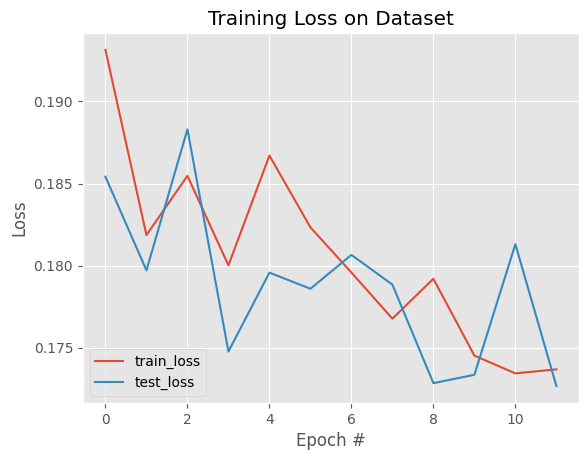

In [73]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()
#plt.savefig(config.PLOT_PATH)
# serialize the model to disk
#torch.save(unet, config.MODEL_PATH)

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [75]:
def make_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0
		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (128, 128))
		orig = image.copy()
		# find the filename and generate the path to ground truth
		# mask
		filename = imagePath.split(os.path.sep)[-1]
		groundTruthPath = os.path.join(config.MASK_DATASET_PATH,
			filename)
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = cv2.imread(groundTruthPath, 0)
		gtMask = cv2.resize(gtMask, (config.INPUT_IMAGE_HEIGHT,
			config.INPUT_IMAGE_HEIGHT))

In [76]:
img_evaldata, mask_evaldata = get_data(img_path, mask_path, [3,4], 100)
print(len(img_evaldata),len(mask_evaldata))

3/2
4/2
0/2
1/2
0/2


C:\Users\rz200\AppData\Local\Temp\ipykernel_14352\2074010971.py:52: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  crop_img = torch.from_numpy(crop_img.astype(np.float))
C:\Users\rz200\AppData\Local\Temp\ipykernel_14352\2074010971.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  crop_mask = torch.from_numpy(crop_mask.astype(np.float))


1/2
100 100


[0.]
(250, 250)
[0. 1.]


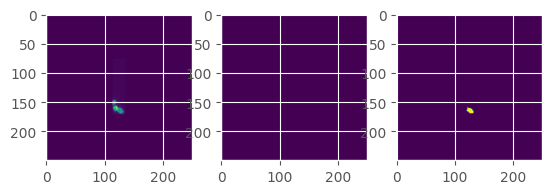

[0.0000000e+00 3.5901897e-39 3.6118118e-39 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(250, 250)
[0. 1.]


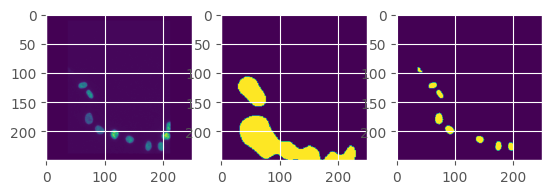

[0.0000000e+00 3.5247813e-39 4.2569233e-39 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(250, 250)
[0. 1.]


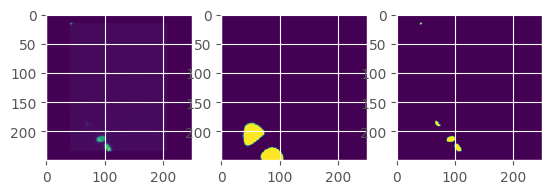

[0.]
(250, 250)
[0.]


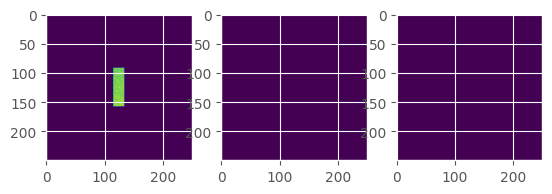

[0.0000000e+00 5.0035744e-39 9.4462381e-38 3.2744998e-37 5.5784046e-37
 1.3507963e-36 3.0950718e-36 7.9542354e-36 9.5064421e-35 1.1420161e-34
 2.6289011e-34 3.2392581e-34 1.2381114e-33 1.6983379e-33 5.3232052e-33
 6.4848926e-32 2.1044784e-31 2.2934179e-31 9.7698078e-30 6.8594890e-29
 7.4042799e-26 6.4787588e-25 1.7016335e-24 8.2017726e-24 1.1748677e-23
 8.7218248e-23 1.2392808e-22 2.7535683e-22 2.8895155e-22 3.8208376e-22
 2.6167122e-21 1.7136622e-20 8.4470852e-19 1.9325172e-18 9.1014137e-18
 2.0890802e-17 3.7906938e-17 7.7107593e-17 9.5256277e-16 9.5806923e-16
 1.3811929e-13 4.3688832e-13 4.7027893e-13 8.4026628e-13 1.7998499e-12
 2.9819021e-12 5.5426384e-12 8.3130300e-12 1.7489672e-10 1.7938619e-09
 3.7280126e-09 1.8812003e-08 5.6693406e-08 1.6397614e-07 1.6630999e-07
 4.2619199e-06 6.1460382e-06 1.2241342e-05 1.8047761e-04 2.8893159e-04
 5.0437200e-04 1.1228359e-02 3.7315108e-02 3.7858158e-02 4.4243887e-01
 9.8872757e-01 9.9833113e-01 9.9879503e-01 9.9916184e-01 9.9959427e-01
 9.999

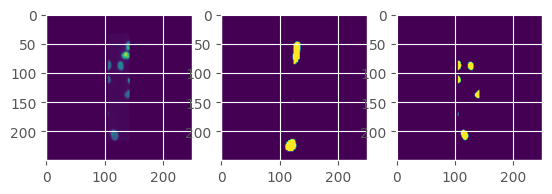

[0.]
(250, 250)
[0.]


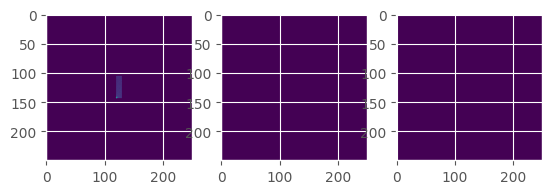

[0.0000000e+00 3.3903183e-39 3.5934239e-39 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(250, 250)
[0. 1.]


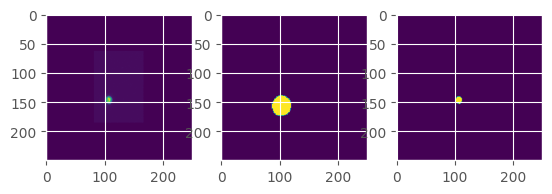

[0.]
(250, 250)
[0.]


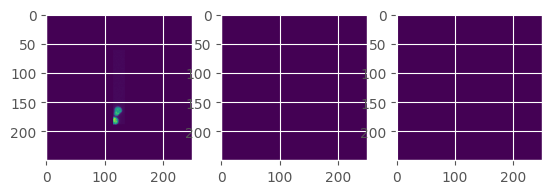

[0.0000000e+00 3.2148393e-39 3.3753230e-39 4.6598597e-39 8.3856769e-39
 9.5137502e-39 1.5720866e-38 7.3918455e-38 1.1065073e-36 1.9688036e-36
 7.0426547e-36 5.3968484e-35 1.1037646e-33 2.4391686e-33 3.1279799e-32
 9.2296983e-32 2.2623103e-31 2.0493947e-30 2.1849675e-30 2.2700316e-30
 2.3339027e-30 2.8571583e-30 3.6066924e-30 4.1356299e-30 4.1456755e-30
 4.5444924e-30 5.4307109e-30 5.4476836e-30 5.4935527e-30 5.8782741e-30
 6.4832670e-30 7.5089676e-30 1.2860015e-29 2.5526850e-29 2.6789081e-29
 3.3644901e-29 4.3948900e-29 5.9636758e-29 7.2958740e-29 6.0410009e-28
 8.0640759e-27 3.5263509e-26 4.9819709e-26 5.0678437e-26 6.8437917e-26
 1.4898516e-25 2.5726034e-25 2.6681031e-25 3.5058307e-25 3.9520253e-25
 4.1607374e-25 4.5045481e-25 6.0281191e-25 7.6442175e-25 8.5903965e-25
 8.8375279e-25 1.2001295e-24 1.2921221e-24 1.3410341e-24 1.9343698e-24
 2.2113203e-24 4.1751757e-24 7.9406415e-24 8.0615968e-24 3.8007164e-23
 3.8589933e-23 4.1688124e-23 6.0523876e-23 1.6881290e-22 1.8736637e-22
 1.896

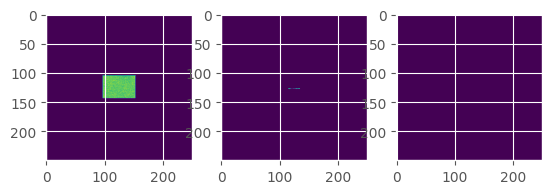

[0.0000000e+00 3.3850971e-39 3.5873157e-39 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(250, 250)
[0. 1.]


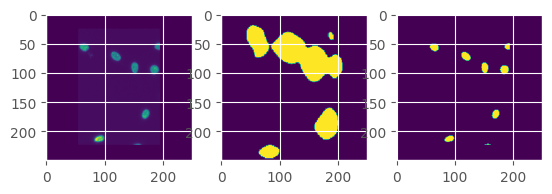

In [77]:
unet.eval()

#num_img = 5

for i in range(10):
    num_img = i
    image = img_evaldata[num_img]
    image_tosave = np.copy(image)
    image_input = image.detach().cpu().numpy()
    image_input = np.expand_dims(image_input,-1)
    image_input = np.moveaxis(image_input,-1,0)
    image_input = torch.from_numpy(image_input)
    image_input = image_input.to('cuda')
    image_input = image_input.float()
    with torch.no_grad():
        predMask = unet(image_input).squeeze()

    plt.subplot(1,3,1)
    #image = image.detach().cpu().numpy()
    image_tosave = np.moveaxis(image_tosave,0,-1)
    plt.imshow(image_tosave)

    plt.subplot(1,3,2)
    predMask = predMask.detach().cpu().numpy()
    print(np.unique(predMask))
    #predMask = np.moveaxis(predMask,0,-1)
    print(predMask.shape)
    #predMask = np.moveaxis(predMask,0,1)
    plt.imshow(predMask)

    plt.subplot(1,3,3)
    mask = mask_evaldata[num_img]
    mask = mask.detach().cpu().numpy()
    print(np.unique(mask))
    mask = np.moveaxis(mask,0,-1)
    plt.imshow(mask)

    plt.show()

In [699]:
print(np.unique(predMask))

[0.00000000e+00 3.05552149e-39 3.45020281e-39 4.32686354e-39
 4.97961919e-39 5.11200126e-39 1.40601986e-38 2.39601214e-38
 3.23162379e-38 1.51440713e-37 2.83511938e-37 3.07629585e-37
 3.75959253e-37 2.13582854e-36 2.01868698e-35 7.92229182e-35
 2.94454401e-34 3.44309872e-34 4.27044975e-34 9.35581372e-34
 1.14771595e-33 1.58986364e-33 1.78205752e-33 1.89489322e-33
 2.01995223e-33 3.48040588e-33 4.15499454e-33 4.32271921e-33
 4.53262614e-33 5.19838610e-33 5.20858902e-33 5.62010976e-33
 6.20127637e-33 1.27561708e-32 3.15665284e-32 3.98530201e-32
 6.67794520e-32 8.31591018e-32 2.30409870e-31 2.15702536e-30
 8.49949673e-30 9.91715119e-30 1.10934723e-29 1.41220243e-29
 1.42321333e-29 1.85015453e-29 2.12362530e-29 4.99833379e-29
 5.39180278e-29 6.99371306e-29 9.98087976e-29 1.83434343e-28
 2.77703113e-28 5.16261073e-28 8.14479240e-28 3.36820457e-27
 4.09597652e-27 4.67386335e-27 5.88202887e-27 9.19580781e-27
 3.92638721e-26 3.79600336e-25 9.16916104e-25 1.35411682e-24
 2.65695255e-24 4.177215

In [ ]:
print(asfoiasofhahof)

NameError: name 'asfoiasofhahof' is not defined

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

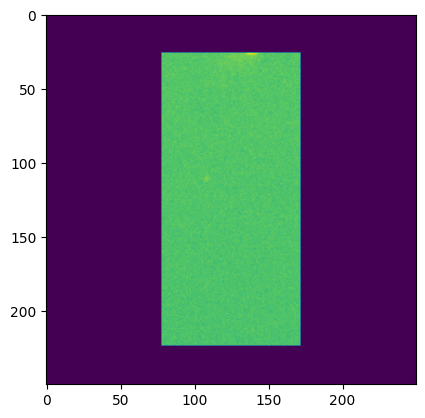

<class 'torch.Tensor'>


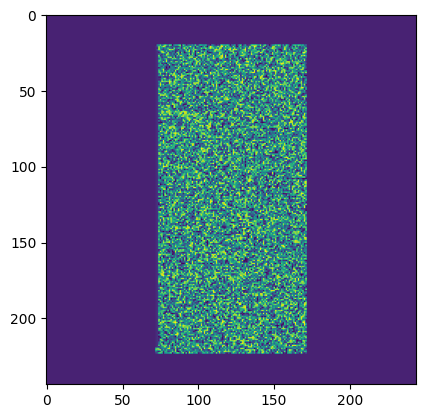

In [ ]:
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage, Resize, ToTensor

transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((250,250)),
	transforms.ToTensor()])

image = X_train[2].astype(int)
plt.imshow(np.squeeze(image))
plt.show()
image = transforms(image)
print(type(image))

b = Block(1,1)
output = b.forward(image.float())
output = ToPILImage()(output)
plt.imshow(output)
plt.show()

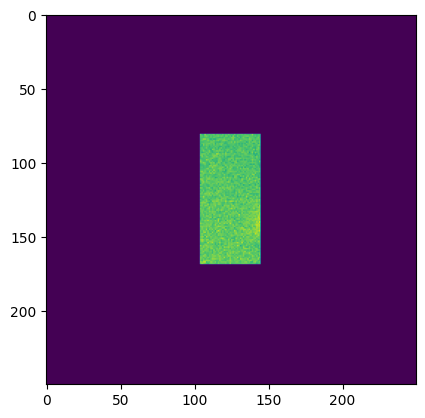

<class 'torch.Tensor'>
torch.Size([1, 1, 250, 250])


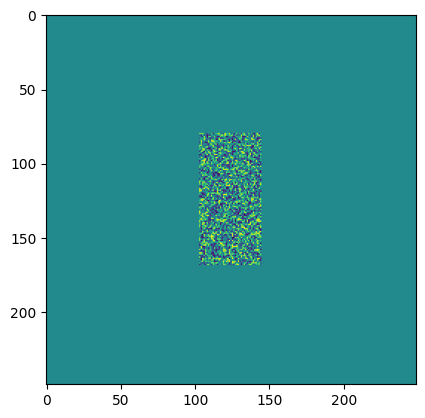

In [ ]:
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage, Resize, ToTensor

transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((250,250)),
	transforms.ToTensor()])

image = X_train[0].astype(int)
plt.imshow(np.squeeze(image))
plt.show()
image = transforms(image)
print(type(image))

conv_ex = Conv2d(1,1,2)
image = image.unsqueeze(0)
print(image.size())
output = conv_ex(image.float())
output = output.squeeze(0)
output = ToPILImage()(output)
plt.imshow(output)

In [ ]:
b = Block(1,1)

img = X_train[0]
img = np.moveaxis(img, -1, 0)
x_data = torch.from_numpy(img)
x_data = x_data.unsqueeze(0)

img = b.forward(x_data)

In [ ]:
plt.imshow(X_train[0])

In [ ]:
#input = torch.empty(2,2,4,4).random_(256)

img = X_train[0]
img = np.moveaxis(img, -1, 0)
x_data = torch.from_numpy(img)
x_data = x_data.unsqueeze(0)
print(x_data.size())

conv_ex = Conv2d(1,3,2)
output = conv_ex(x_data)

plt.imshow(output)

In [ ]:
conv_ex = Conv2d(2,3,2)
x = random.random((25,25,1))
output = conv_ex(x)

In [ ]:
from numpy import random

b = Block(1,1)
x = random.random((25,25,3))
plt.imshow(x)
plt.show()
b.forward(x)